In [14]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout


#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


def get_deepchem_idx(df):
    """ deepchem dataset"""
    deepchem_data_name = './Lipop_deepchem.data'
    if os.path.exists(deepchem_data_name):
        train_df,valid_df,test_df = load(deepchem_data_name)
    else:
        import deepchem as dc
        task, train_valid_test, _ = dc.molnet.load_lipo(featurizer='Raw',split = 'random')
        train, valid, test = train_valid_test
        print('training set: %s, valid set: %s, test set %s' % (len(train.ids), len(valid.ids), len(test.ids)))
        train_df = df[df.smiles.isin(train.ids)]
        valid_df = df[df.smiles.isin(valid.ids)]
        test_df = df[df.smiles.isin(test.ids)]
        dump((train_df,valid_df,test_df), deepchem_data_name)
    train_idx = train_df.index
    valid_idx = valid_df.index
    test_idx = test_df.index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx


def get_attentiveFP_idx(df):
    """ attentiveFP dataset"""
    train, valid,test = load('./Lipop_attentiveFP.data')
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 


def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs

    
def SinglePathClassificationModel(molmap_shape,  n_outputs = 1, strides = 1):
    """molmap_shape: w, h, c"""
    
    assert len(molmap_shape) == 3
    inputs = Input(molmap_shape)
    
    conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(inputs)
    
    conv1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(conv1) #p1
    
    incept1 = Inception(conv1, strides = 1, units = 32)
    
    incept1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(incept1) #p2
    
    incept2 = Inception(incept1, strides = 1, units = 64)
    
    #flatten
    flat1 = GlobalMaxPool2D()(incept2)   
    d1 = Dense(128,activation='relu')(flat1)
    d1 = Dense(64,activation='relu')(d1)
    outputs = Dense(n_outputs,activation='linear')(d1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


def DoublePathClassificationModel(molmap1_size, molmap2_size, n_outputs = 1):
    
    ## first inputs
    d_inputs1 = Input(molmap1_size)
    d_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(d_inputs1)
    d_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_conv1) #p1
    d_incept1 = Inception(d_pool1, strides = 1, units = 32)
    d_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_incept1) #p2
    d_incept2 = Inception(d_pool2, strides = 1, units = 64)
    d_flat1 = GlobalMaxPool2D()(d_incept2)

    
    ## second inputs
    f_inputs1 = Input(molmap2_size)
    f_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(f_inputs1)
    f_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_conv1) #p1
    f_incept1 = Inception(f_pool1, strides = 1, units = 32)
    f_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_incept1) #p2
    f_incept2 = Inception(f_pool2, strides = 1, units = 64)
    f_flat1 = GlobalMaxPool2D()(f_incept2)    
    
    ## concat
    merge = Concatenate()([d_flat1, f_flat1]) 
    d1 = Dense(256,activation='relu')(merge)
    d1 = Dense(128,activation= 'relu')(d1)
    d1 = Dense(32,activation= 'relu')(d1)


    outputs = Dense(n_outputs, activation='linear')(d1)
    
    model = tf.keras.Model(inputs=[d_inputs1, f_inputs1], outputs=outputs)
    
    return model

In [15]:

from cbks import RegressionPerformance, EarlyStoppingAtMinLoss

#load dataset
data = dataset.load_Lipop()
df = data.data
Y = data.y

# featurelizer by molmap
X1_name =  './descriptor_grid_split.data'
X2_name =  './fingerprint_grid_split.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    #mp1 = molmap.MolMap(ftype = 'descriptor', fmap_type = 'grid', split_channels=True)
    #mp1.fit(method = 'umap', min_dist = 0.1, n_neighbors = 50)
    #mp1.save('../descriptor_grid_split.mp')
    mp1 = loadmap('../../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(data.x, n_jobs = 8)
    dump(X1, X1_name)

if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    #mp2 = molmap.MolMap(ftype = 'fingerprint', flist = flist, fmap_type = 'grid', split_channels=True)
    #mp2.fit(method = 'umap')
    #mp2.save('../fingerprint_grid_split.mp')
    mp2 = loadmap('../../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(data.x, n_jobs = 8)
    dump(X2, X2_name)

epochs = 500
patience = 20
batch_size = 128
learning_rate=0.0001

seed = 77
dtype = 'attentiveFP'
mtype = 'both'


np.random.seed(seed)
tf.set_random_seed(seed)                

## train, valid, test split                
if dtype == 'attentiveFP':
    train_idx, valid_idx, test_idx = get_attentiveFP_idx(df) #random seed has no effects
else:
    train_idx, valid_idx, test_idx = get_deepchem_idx(df) #random seed has no effects              

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

print(len(train_idx), len(valid_idx), len(test_idx))    
molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]

if mtype == 'SinglePath_descriptor':
    model = SinglePathClassificationModel(molmap1_size, n_outputs = Y.shape[1])
    trainX = X1[train_idx]                
    validX = X1[valid_idx]
    testX = X1[test_idx]

elif mtype == 'SinglePath_fingerprint':
    model = SinglePathClassificationModel(molmap2_size, n_outputs = Y.shape[1])
    trainX = X2[train_idx]                
    validX = X2[valid_idx]
    testX = X2[test_idx]                

else:
    model = DoublePathClassificationModel(molmap1_size, molmap2_size, n_outputs = Y.shape[1])
    trainX = (X1[train_idx], X2[train_idx])    
    validX = (X1[valid_idx], X2[valid_idx])                    
    testX = (X1[test_idx], X2[test_idx])                    



total samples: 4200
training set: 3360, valid set: 420, test set 420
training set: 3360, valid set: 420, test set 420
3360 420 420


In [16]:

earlystop = EarlyStoppingAtMinLoss(patience=patience, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY))
lr = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = 'mse')

model.fit(trainX, trainY, batch_size=batch_size, 
          epochs=epochs, verbose= 0, shuffle = True, 
          validation_data = (validX, validY), 
          callbacks=[performace, earlystop]) 

epoch: 0001, loss: 2.8032 - val_loss: 1.5310; rmse: 1.1832 - rmse_val: 1.2373;  r2: 0.0158 - r2_val: 0.0166                                                                                                    
epoch: 0002, loss: 1.4053 - val_loss: 1.4848; rmse: 1.1687 - rmse_val: 1.2185;  r2: 0.0397 - r2_val: 0.0462                                                                                                    
epoch: 0003, loss: 1.3348 - val_loss: 1.4258; rmse: 1.1400 - rmse_val: 1.1941;  r2: 0.0863 - r2_val: 0.0841                                                                                                    
epoch: 0004, loss: 1.2771 - val_loss: 1.3577; rmse: 1.1114 - rmse_val: 1.1652;  r2: 0.1315 - r2_val: 0.1279                                                                                                    
epoch: 0005, loss: 1.2075 - val_loss: 1.2647; rmse: 1.0754 - rmse_val: 1.1246;  r2: 0.1870 - r2_val: 0.1876                                                             

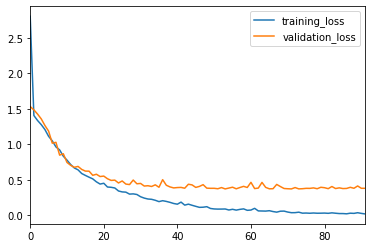

In [17]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [18]:
train_perf = performace.evaluate(trainX, trainY)
valid_perf = performace.evaluate(validX, validY)
test_perf = performace.evaluate(testX, testY)

best_epoch = earlystop.best_epoch
paras = model.count_params()

res = {'dataset': dtype, 'model':mtype, 'trainable_paras':paras, 
       'best_epoch': best_epoch, 'lr': learning_rate, 
       'batch_size': batch_size, 'random_seed': seed,
       'train_samples':len(train_idx),
       'valid_samples':len(valid_idx), 
       'test_samples':len(test_idx),
       'train_rmse':np.nanmean(train_perf[0]),
       'valid_rmse': np.nanmean(valid_perf[0]),
       'test_rmse':np.nanmean(test_perf[0]),
       'train_r2':np.nanmean(train_perf[1]),
       'valid_r2': np.nanmean(valid_perf[1]),
       'test_r2':np.nanmean(test_perf[1]),
      }


In [19]:
res['test_rmse']

0.6466519335827382

In [20]:
res

{'dataset': 'attentiveFP',
 'model': 'both',
 'trainable_paras': 803681,
 'best_epoch': 71,
 'lr': 0.0001,
 'batch_size': 128,
 'random_seed': 77,
 'train_samples': 3360,
 'valid_samples': 420,
 'test_samples': 420,
 'train_rmse': 0.17260548465246406,
 'valid_rmse': 0.6095254303377118,
 'test_rmse': 0.6466519335827382,
 'train_r2': 0.9790549568303953,
 'valid_r2': 0.7613505188968319,
 'test_r2': 0.7232214791759088}